In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import tflearn
import os
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers import regression
from tflearn.layers.core import input_data, dropout, fully_connected

Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


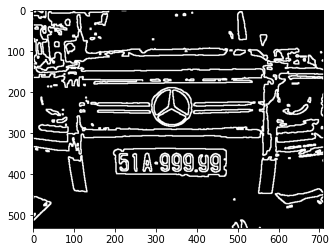

In [2]:
im = cv2.imread("./car/test.jpg")
im_gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
# noise_removal = cv2.bilateralFilter(im_gray,9,75,75)
noise_removal = cv2.medianBlur(im_gray, 5)
# equal_histogram = cv2.equalizeHist(noise_removal)
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
kernel = np.ones((3,3), np.uint8)
morph_image = cv2.morphologyEx(noise_removal,cv2.MORPH_OPEN,kernel,iterations=20)
sub_morp_image = cv2.subtract(noise_removal,morph_image)
ret,thresh_image = cv2.threshold(sub_morp_image,0,255,cv2.THRESH_OTSU)
canny_image = cv2.Canny(thresh_image,250,255)
dilated_image = cv2.dilate(canny_image,kernel,iterations=1)
plt.imshow(dilated_image, cmap='Greys_r')

In [3]:
new,contours, hierarchy = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours= sorted(contours, key = cv2.contourArea, reverse = True)[:10]
screenCnt = None
for c in contours:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.06 * peri, True) 
    if len(approx) == 4:
            screenCnt = approx
            break

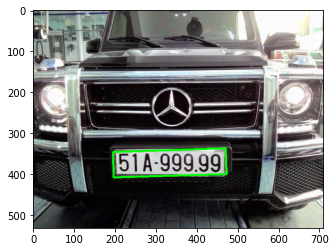

In [4]:
img1 = im.copy()
hull = cv2.convexHull(screenCnt)
simplified_cnt = cv2.approxPolyDP(hull,0.001*cv2.arcLength(hull,True),True)
rect = cv2.minAreaRect(simplified_cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)
img = cv2.drawContours(img1,[box],0,(0,255,0),3)
plt.imshow(img)

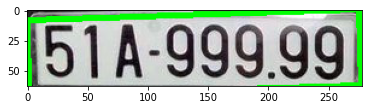

In [5]:
x,y,w,h = cv2.boundingRect(simplified_cnt)
final_image = img[y:y+h, x:x+w]
plt.imshow(final_image, cmap='Greys_r')
roi = final_image

In [6]:
roi_gray = cv2.cvtColor(roi,cv2.COLOR_BGR2GRAY)
roi_blur = cv2.GaussianBlur(roi_gray,(3,3),1)
ret,thre = cv2.threshold(roi_blur,120,255,cv2.THRESH_BINARY_INV)
kerel3 = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
thre_mor = cv2.morphologyEx(thre,cv2.MORPH_DILATE,kerel3)
_,cont,hier = cv2.findContours(thre_mor,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

In [7]:
areas_ind = {}
areas = []
for ind,cnt in enumerate(cont) :
  area = cv2.contourArea(cnt)
  areas_ind[area] = ind
  areas.append(area)
areas = sorted(areas,reverse=True)[0:8]

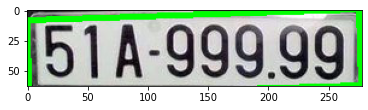

In [8]:
for count,i in enumerate(areas):
 (x,y,w,h) = cv2.boundingRect(cont[areas_ind[i]])
 num = cv2.cvtColor(final_image[y:y+h, x:x+w],cv2.COLOR_BGR2GRAY)
 cv2.imwrite("./result/result{}.png".format(count), num)
 cv2.imshow('img', final_image[y:y+h, x:x+w])
plt.imshow(cv2.cvtColor(roi,cv2.COLOR_BGR2RGB))

In [9]:
IMG_SIZE = 28
N_CLASSES = 10

network = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1]) #1

network = conv_2d(network, 32, 3, activation='relu') #2
network = max_pool_2d(network, 2) #3

network = conv_2d(network, 64, 3, activation='relu')
network = max_pool_2d(network, 2)

network = conv_2d(network, 32, 3, activation='relu')
network = max_pool_2d(network, 2)

network = conv_2d(network, 64, 3, activation='relu')
network = max_pool_2d(network, 2)

network = conv_2d(network, 32, 3, activation='relu')
network = max_pool_2d(network, 2)

network = conv_2d(network, 64, 3, activation='relu')
network = max_pool_2d(network, 2)

network = fully_connected(network, 1024, activation='relu') #4
network = dropout(network, 0.8) #5

network = fully_connected(network, N_CLASSES, activation='softmax')#6
network = regression(network)

model = tflearn.DNN(network) #7

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
model.load('./model/numberModel.tflearn')

INFO:tensorflow:Restoring parameters from C:\Users\tri.tranminh\model\numberModel.tflearn


In [11]:
IMG_DIR = 'C:/Users/tri.tranminh/result'
for img in os.listdir(IMG_DIR):
        img_array = cv2.imread(os.path.join(IMG_DIR,img), cv2.IMREAD_GRAYSCALE)
        resized_image = cv2.resize(img_array, (28, 28))
        img_flatten = resized_image.flatten()
        data = img_flatten.reshape(-1, 28, 28, 1)
        test_logits = model.predict(data)
        test_logits = np.argmax(test_logits, axis=-1)
        print(test_logits)

[1]
[8]
[2]
[2]
[1]
[3]
[5]
[7]
